# Test Nex calc updates

In [44]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
from astropy.coordinates import SkyCoord
from astropy import units as u
import crpropa

import sys
sys.path.append("../../../../fancy")
from fancy import Model, Data
#from fancy.detector.TA2015 import detector_properties, alpha_T, M, Eth
from fancy.detector.auger2014 import detector_properties, alpha_T, M, Eth
from fancy.interfaces.stan import uv_to_coord
from fancy.detector.vMF.vmf import sample_vMF, sample_sphere
from fancy.plotting import AllSkyMapCartopy as AllSkyMap

Simulate UHECRs from sources, including the EGMF

In [45]:
stan_path = "../../stan/"
source_file = "../../data/sourcedata.h5"
sim_file_name = os.path.join(stan_path, "single_source_sim.stan")
random_seed = 42
ptype = "p"

# Compile model
simulation = Model(sim_filename=sim_file_name, include_paths=stan_path)
simulation.compile()

# Define source catalogue and detector exposure
source_type = "SBG_23"

sim_output_file = 'output/joint_gmf_model_simulation_{0}_{1}_{2}.h5'.format(source_type, random_seed, ptype)

data = Data()
data.add_source(source_file, source_type)
data.add_detector(detector_properties)

Simulate events from a single source

In [46]:
# Input parameters for simulation
N = 1000

# Pick a source
i_src = 1 
D = data.source.distance[i_src]
varpi = data.source.unit_vector[i_src]
coords_src = data.source.coord[i_src]

# Convert scale for sampling
D = (D * 3.086) / 100 

sim_input = {}
sim_input["N"] = N
sim_input["D"] = D
sim_input["varpi"] = varpi
sim_input["alpha"] = 3.0
sim_input["B"] = 50 # nG
sim_input["Eth"] = 20 # EeV
sim_input["Z"] = 1

In [47]:
sim_output = simulation.simulation.sample(
    data=sim_input,
    iter_sampling=1,
    chains=1,
    fixed_param=True,
    seed=random_seed,
    show_console=False);

# Simulate deflections based on kappa
kappas = sim_output.stan_variable("kappa")[0]
omega_gb = []
for k in kappas:
    omega_gb.append(sample_vMF(varpi, k, 1))
coords_gb = uv_to_coord(omega_gb)[0]

17:24:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

17:24:16 - cmdstanpy - INFO - CmdStan done processing.


Make a plot

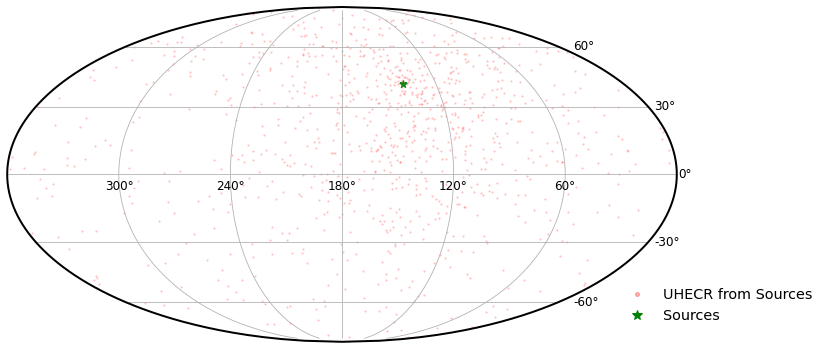

In [48]:
plt.style.use("minimalist")

lons_gb, lats_gb = coords_gb.galactic.l.deg, coords_gb.galactic.b.deg
lons_src, lats_src = coords_src.galactic.l.deg, coords_src.galactic.b.deg

skymap = AllSkyMap(lon_0=180)
skymap.set_gridlines()
skymap.scatter(lons_gb, lats_gb, s=4.5, color="r", alpha=0.25, label="UHECR", lw=0)
skymap.scatter(lons_src, lats_src, s=60.0, color="g", alpha=0.9, marker="*", label="Sources")

handles = [mlines.Line2D([], [], color='r', marker='o', lw=0,
                          markersize=4, alpha=0.3, label="UHECR from Sources"),
            mlines.Line2D([], [], color='g', marker='*', lw=0,
                          markersize=10, label="Sources")]

skymap.legend(handles=handles, bbox_to_anchor=(0.9, 0.2)) 

Now do some lensing

In [49]:
path_to_lens = os.path.join("lens", "JF12full_Gamale", "lens.cfg")
lens = crpropa.MagneticLens(path_to_lens)

In [50]:
energies_gb = sim_output.stan_variable("Earr")[0] * crpropa.EeV  # UHECR energy at gal. boundary
pid = crpropa.nucleusId(1, sim_input["Z"])

MC = crpropa.ParticleMapsContainer()

# divide energy by Z to get rigidity (to account for composition)
rigidities_gb = np.array(
    [np.float64(energy_gb) / sim_input["Z"] for energy_gb in energies_gb])

# add particle to map container
# Coordinate transformation is based on making the final map used for sampling
# to be sampled in the correct coordinates.
for i in range(N):
    c_gal = coords_gb[i].galactic
    MC.addParticle(pid, rigidities_gb[i], c_gal.l.rad, c_gal.b.rad)

# apply lens of b-field model to get map of uhecrs at earth
# full lens to account for turbulent effects
lens.normalizeLens()
MC.applyLens(lens)

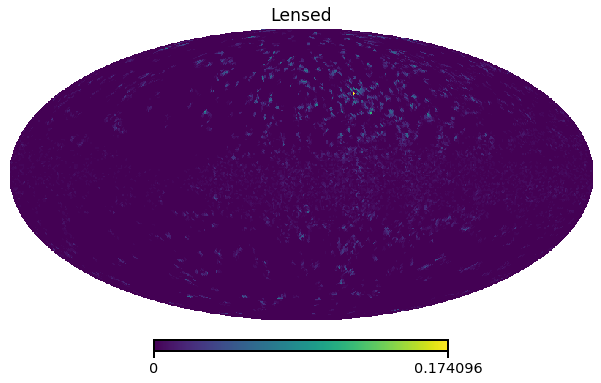

In [51]:
import healpy

crMap = np.zeros(49152)
for pid in MC.getParticleIds():
    energies = MC.getEnergies(int(pid))
    for i, energy in enumerate(energies):
        crMap += MC.getMap(int(pid), energy * crpropa.eV )

#plot maps using healpy
healpy.mollview(map=crMap, title='Lensed', rot=(180, 0, 0), flip="astro")
#plt.savefig('lensed_map.png')

In [52]:
_, _, lons_earth_src, lats_earth_src = MC.getRandomParticles(N)
omega_earth_src = SkyCoord(lons_earth_src * u.rad,
                     lats_earth_src * u.rad,
                     frame="galactic")
lons_src, lats_src = coords_src.galactic.l.deg, coords_src.galactic.b.deg

In [65]:
# Exposure
num_points = 10000
rightascensions = np.linspace(-180, 180, num_points)
limiting_dec = data.detector.limiting_dec.deg
boundary_decs = np.tile(limiting_dec, num_points)
c = SkyCoord(ra = rightascensions * u.degree,
             dec = boundary_decs * u.degree, frame = 'icrs')
exp_lon = c.galactic.l.deg
exp_lat = c.galactic.b.deg

if limiting_dec < 0:
    mask_in_fov = omega_earth_src.icrs.dec.deg > limiting_dec
    src_in_fov = coords_src.icrs.dec.deg > limiting_dec
else:
    mask_in_fov = omega_earth_src.icrs.dec.deg < limiting_dec
    src_in_fov = coords_src.icrs.dec.deg < limiting_dec

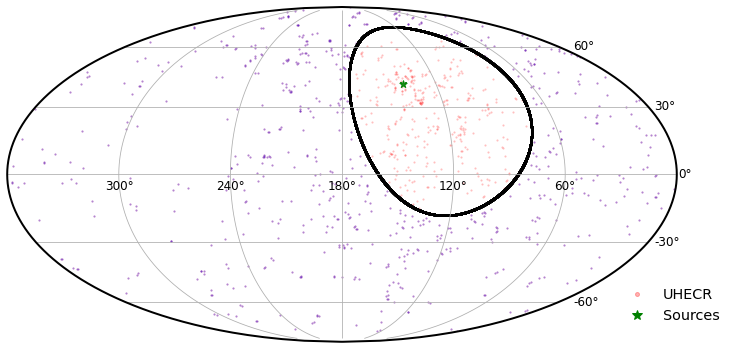

In [61]:
skymap = AllSkyMap(lon_0=180)
skymap.set_gridlines()
skymap.scatter(omega_earth_src.galactic.l.deg, omega_earth_src.galactic.b.deg, s=4.5,
                color="r", alpha=0.25, lw=0., label="UHECRs")
skymap.scatter(omega_earth_src.galactic.l.deg[mask_in_fov], omega_earth_src.galactic.b.deg[mask_in_fov], s=4.5, color="b", alpha=0.3, lw=0, label="in Fov")
skymap.scatter(lons_src, lats_src, s=60.0, color="g", alpha=0.9, marker="*", label="Source")
skymap.scatter(exp_lon, exp_lat, s=2, color="k", alpha=1)
handles = [
    mlines.Line2D([], [],
                    color='r',
                    marker='o',
                    lw=0,
                    markersize=4,
                    alpha=0.3,
                    label="UHECR"),
    mlines.Line2D([], [],
                    color='g',
                    marker='*',
                    lw=0,
                    markersize=10,
                    label="Sources")
]
skymap.legend(handles=handles, bbox_to_anchor=(0.9, 0.2))

In [66]:
fraction_in_fov = len(omega_earth_src[mask_in_fov]) / N
fraction_in_fov

0.642

In [68]:
factor = 1